<a href="https://colab.research.google.com/github/nataliakartasheva/AMD_MBA/blob/master/AMD_MBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market Basket analyses on IMDB dataset

## Connect to kaggle and download datasets to drive memory

In [1]:
! pip install kaggle
! pip install pyspark

In [2]:
# creating folders for kaggle api configuration file import
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

import os
if os.path.isfile('/content/drive/MyDrive/Kaggle/kaggle.json') == False:
  from google.colab import files
  print('Please upload your kaggle.json')
  uploaded = files.upload()

  os.mkdir('/content/drive/MyDrive/Kaggle/kaggle.json')

  import shutil
  shutil.move('/content/kaggle.json', '/content/drive/MyDrive/Kaggle/kaggle.json')

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle'

Mounted at /content/drive


In [3]:
# downloading datasets using kaggle api
!kaggle datasets download -d ashirwadsangwan/imdb-dataset 
!unzip imdb-dataset.zip

imdb-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  imdb-dataset.zip
replace name.basics.tsv.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace name.basics.tsv/name.basics.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace title.akas.tsv.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace title.akas.tsv/title.akas.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace title.basics.tsv.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace title.basics.tsv/title.basics.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace title.principals.tsv.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace title.principals.tsv/title.principals.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace title.ratings.tsv.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace title.ratings.tsv/title.ratings.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## Init spark session and download datasets to local memory

In [4]:
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, ArrayType, DoubleType
from pyspark.sql.functions import countDistinct, collect_set, udf, col, count, collect_set, lit, when, concat_ws, substring, length, col, expr, split, size

import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import time
from datetime import time, date, datetime

import pandas as pd
import numpy as np
from wordcloud import WordCloud

import itertools
from operator import add

In [5]:
# initialize spark session
conf = SparkConf().setAppName("IMDB_MarketBasketAnalysis")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '32G')
        .set('spark.driver.memory', '128G')
        .set('spark.driver.maxResultSize', '24G'))

sc = SparkContext(conf= conf)
spark = SparkSession.builder.appName("IMDB_MarketBasketAnalysis").getOrCreate()

In [6]:
spark

In [7]:
#download datasets to local memmory
principals_path = '/content/title.principals.tsv.gz'
movies_path = '/content/title.basics.tsv.gz'
persons_path = '/content/name.basics.tsv.gz'

principals = spark.read.csv(principals_path, sep='\t', header=True, inferSchema=True)
movies = spark.read.csv(movies_path, sep= '\t', header=True, inferSchema=True)
persons = spark.read.csv(persons_path, sep='\t' , header=True, inferSchema=True)

#create a temp view
persons.createOrReplaceTempView('persons')
principals.createOrReplaceTempView('principals')
movies.createOrReplaceTempView('movies')

## Data exploration

In [8]:
# view each table separately
print('principals')
principals.show(5)
print('movies')
movies.show(5)
print('persons')
persons.show(5)

principals
+---------+--------+---------+---------------+--------------------+-----------+
|   tconst|ordering|   nconst|       category|                 job| characters|
+---------+--------+---------+---------------+--------------------+-----------+
|tt0000001|       1|nm1588970|           self|                  \N|["Herself"]|
|tt0000001|       2|nm0005690|       director|                  \N|         \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|         \N|
|tt0000002|       1|nm0721526|       director|                  \N|         \N|
|tt0000002|       2|nm1335271|       composer|                  \N|         \N|
+---------+--------+---------+---------------+--------------------+-----------+
only showing top 5 rows

movies
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|       

In [9]:
# checking if there are missings in important columns
print('principals_tconst:',principals.filter(col('tconst').isNull()).count())
print('principals_nconst:',principals.filter(col('nconst').isNull()).count())

print('movies_titleType',movies.filter(col('titleType').isNull()).count())
print('movies_primaryTitle:',movies.filter(col('primaryTitle').isNull()).count())

print('persons_nconst:',persons.filter(col('nconst').isNull()).count())
print('persons_primaryName:',persons.filter(col('primaryName').isNull()).count())


# no missings found - no need in extra proccessing of None's

principals_tconst: 0
principals_nconst: 0
movies_titleType 0
movies_primaryTitle: 0
persons_nconst: 0
persons_primaryName: 0


In [10]:
#checking the data types
print('principals')
principals.printSchema()
print('movies')
movies.printSchema()
print('persons')
persons.printSchema()

# correct data types

principals
root
 |-- tconst: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- nconst: string (nullable = true)
 |-- category: string (nullable = true)
 |-- job: string (nullable = true)
 |-- characters: string (nullable = true)

movies
root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)

persons
root
 |-- nconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- birthYear: string (nullable = true)
 |-- deathYear: string (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- knownForTitles: string (nullable = true)



## Finding insights

In [11]:
# 0. construct a table: actor and all the movies he's played to
query_movies_and_actors = """SELECT movies.primaryTitle, persons.primaryName
                             FROM movies
                             INNER JOIN principals
                             ON principals.tconst = movies.tconst
                             INNER JOIN persons
                             ON persons.nconst = principals.nconst
                             WHERE (category = 'actor' or category = 'actress') and (movies.titleType = 'movie');
                             """
movies_and_actors = spark.sql(query_movies_and_actors)
movies_and_actors.createOrReplaceTempView('movies_and_actors')
movies_and_actors.show(5)

+--------------------+------------+
|        primaryTitle| primaryName|
+--------------------+------------+
|         Goin' South|John Belushi|
|National Lampoon'...|John Belushi|
|  Continental Divide|John Belushi|
|           Neighbors|John Belushi|
|                1941|John Belushi|
+--------------------+------------+
only showing top 5 rows



actors_with_top_n_of_movies
+----------------+--------+
|     primaryName|n_movies|
+----------------+--------+
|    Brahmanandam|     797|
|     Adoor Bhasi|     585|
|Matsunosuke Onoe|     565|
|    Eddie Garcia|     507|
|      Prem Nazir|     436|
|    Sung-il Shin|     411|
|    Paquito Diaz|     391|
|Masayoshi Nogami|     387|
|       Mammootty|     380|
|  Aachi Manorama|     356|
+----------------+--------+
only showing top 10 rows



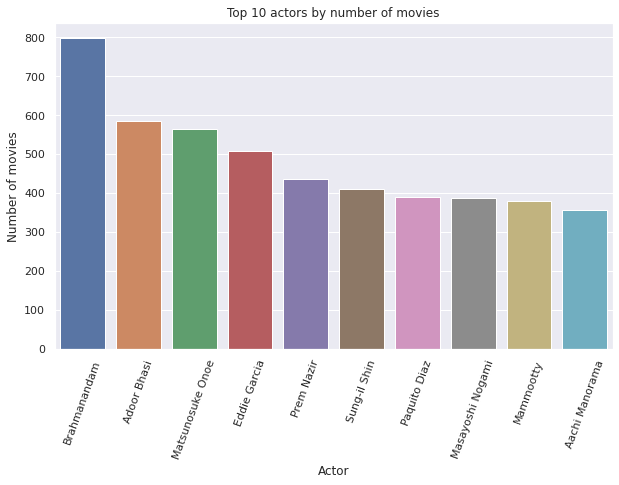

In [12]:
# 1. construct a table to see actors with the biggest number of movies
query_actors_with_top_n_of_movies = """SELECT primaryName, COUNT(*) AS n_movies
                                       FROM movies_and_actors
                                       GROUP BY primaryName
                                       ORDER BY n_movies desc
                                       """

actors_with_top_n_of_movies = spark.sql(query_actors_with_top_n_of_movies)
actors_with_top_n_of_movies.createOrReplaceTempView('actors_with_top_n_of_movies')
print('actors_with_top_n_of_movies')
actors_with_top_n_of_movies.show(10)

# plot actors with top 10 number of movies
top_10_actors = actors_with_top_n_of_movies.limit(10).cache()
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.barplot(x = "primaryName", y = "n_movies", data = top_10_actors.toPandas())
ax.set(title = "Top 10 actors by number of movies", xlabel = "Actor", ylabel = "Number of movies")
ax.set_xticklabels(ax.get_xticklabels(), rotation=70);

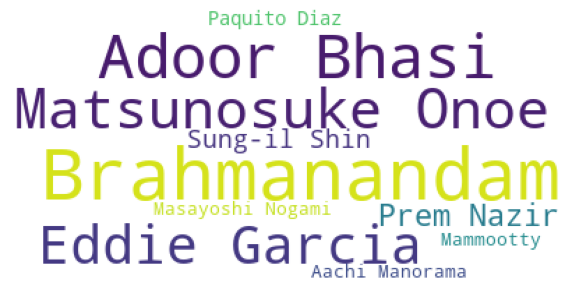

In [13]:
# 2. actors with top 10 number of movies as a worldcloud  
wordcloud_list_of_dicts = top_10_actors.select('primaryName', 'n_movies').rdd.map(lambda row: row.asDict()).collect()
wordcloud_dict = {dict_['primaryName'] : dict_['n_movies'] for dict_ in wordcloud_list_of_dicts}
wordcloud_object = WordCloud(background_color = "white").fit_words(wordcloud_dict)

# displaying the generated image
plt.figure(figsize = (10, 6))
plt.imshow(wordcloud_object)
plt.axis("off")
plt.show();

movies_with_top_n_of_actors
+------------+--------+
|primaryTitle|n_actors|
+------------+--------+
|      Hamlet|     145|
|     Macbeth|     141|
|   Honeymoon|     139|
|      Broken|     131|
|       Alone|     128|
|        Love|     127|
|      Desire|     125|
|      Mother|     123|
|  Homecoming|     117|
|The Stranger|     115|
+------------+--------+
only showing top 10 rows



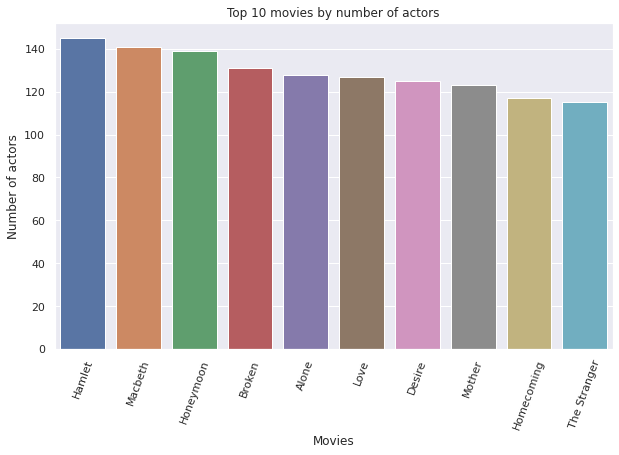

In [14]:
# 3. construct a table to see movies with the biggest number of actors
query_movies_with_top_n_of_actors = """SELECT primaryTitle, COUNT(*) AS n_actors
                                       FROM movies_and_actors
                                       GROUP BY primaryTitle
                                       ORDER BY n_actors desc
                                       """

movies_with_top_n_of_actors = spark.sql(query_movies_with_top_n_of_actors)
movies_with_top_n_of_actors.createOrReplaceTempView('movies_with_top_n_of_actors')
print('movies_with_top_n_of_actors')
movies_with_top_n_of_actors.show(10)

# plot movies with top 10 number of actors
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.barplot(x = "primaryTitle", y = "n_actors", data = movies_with_top_n_of_actors.limit(10).toPandas())
ax.set(title = "Top 10 movies by number of actors", xlabel = "Movies", ylabel = "Number of actors")
ax.set_xticklabels(ax.get_xticklabels(), rotation=70);

## Market basket analyses using Apriori Algorithm

### 1.Data organisation

In [15]:
# making a dataframe of movies and actors:  'movie' : ['actor_1', 'actor_2', 'actor_3']
baskets_unqiue_items_df = movies_and_actors.groupBy('primaryTitle').agg(collect_set('primaryName').alias('items'))

# making a list of actors per each movie: [['actor_1', 'actor_2', 'actor_3'],['actor_1', 'actor_2', 'actor_3']]    
list_of_items_per_each_basket = list(baskets_unqiue_items_df.select('items').toPandas()['items'])

# making a tuple of actors per each movie: [('actor_1', 'actor_2', 'actor_3'),('actor_1', 'actor_2', 'actor_3')] 
tuple_of_items_per_each_basket = [tuple(i) for i in list_of_items_per_each_basket]

toPandas is the most efficient way to make transformation to list here <br>
<a href="https://mungingdata.com/pyspark/column-to-list-collect-tolocaliterator/">Reference</a>

### 2.Import apriori algorithm

In [16]:
!pip install efficient_apriori
from efficient_apriori import apriori

### 3.Using apriori algorithm to organised data

<b>Hyperparameters of the algorithm:</b>
    
 <li>min_support - the threshold that shows the minimun wanted number of movies played together</li>
 <li>min_confidence - allows to delete rules with low confidence</li>

In [17]:
# we choose at least 100 joint occurences
min_support = 100/len(tuple_of_items_per_each_basket) #has to be expressed as a percentage for efficient-apriori

# we now set min_confidence = 0 to obtain all the rules
min_confidence = 0

# apply apriori algorithm
itemsets, rules = apriori(tuple_of_items_per_each_basket, min_support=min_support, min_confidence=min_confidence)

### 4.Checking the result

In [18]:
# function to transform the result to a dataframe
def create_dataframe_with_result(n_actors):
    columns = ['actors','joint_apperaneces']
    data = [(tuple(key), value) for key, value in itemsets[n_actors].items()]
    mba_result_df = spark.createDataFrame(data=data, schema = columns)
    mba_result_df = mba_result_df.orderBy(col('joint_apperaneces').desc())
    return mba_result_df

In [19]:
# results
result_singletons = dict(sorted(itemsets[1].items(), key=lambda item: item[1], reverse=True))
result_pair = dict(sorted(itemsets[2].items(), key=lambda item: item[1], reverse=True))
result_triple = dict(sorted(itemsets[3].items(), key=lambda item: item[1], reverse=True))

# results_as_spark_dataframes
result_singletons_df = create_dataframe_with_result(n_actors = 1)
result_pair_df = create_dataframe_with_result(n_actors = 2)
result_triple_df = create_dataframe_with_result(n_actors = 3)

# results_as_pandas_dataframes
result_singletons_pdf = result_singletons_df.toPandas()
result_pair_pdf = result_pair_df.toPandas()
result_triple_pdf = result_triple_df.toPandas()

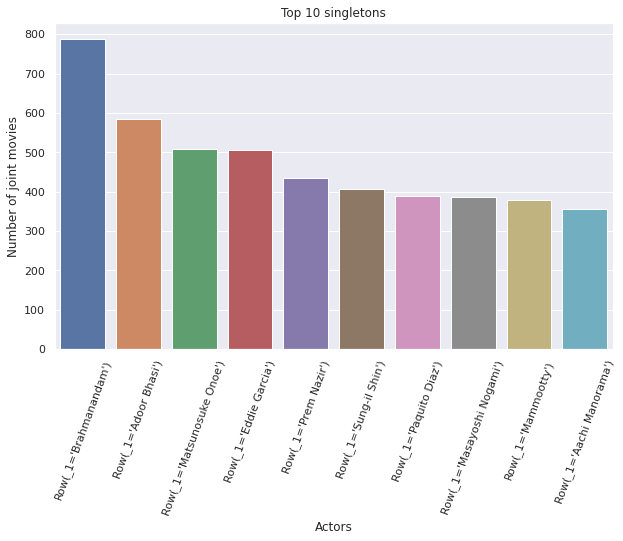

In [20]:
# plot top 10 frequent singletons
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.barplot(x = "actors", y = "joint_apperaneces", data = result_singletons_pdf[:10])
ax.set(title = "Top 10 singletons", xlabel = "Actors", ylabel = "Number of joint movies")
ax.set_xticklabels(ax.get_xticklabels(), rotation=70);

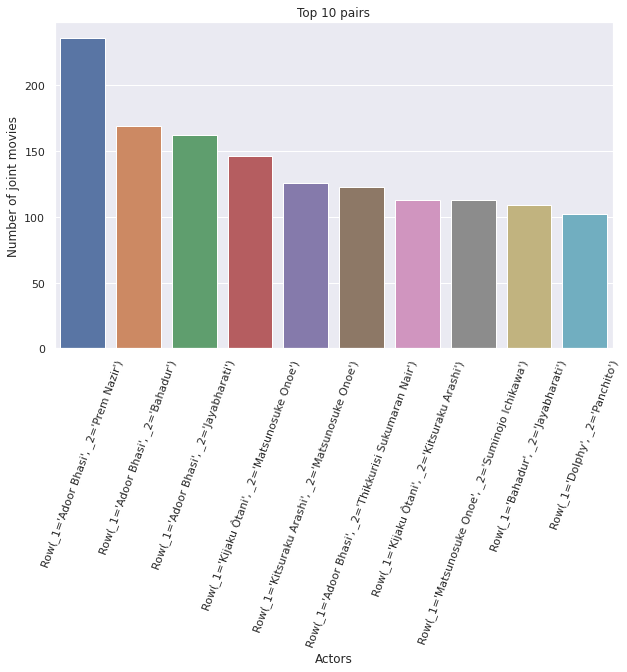

In [21]:
# plot top 10 frequent pairs
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.barplot(x = "actors", y = "joint_apperaneces", data = result_pair_pdf[:10])
ax.set(title = "Top 10 pairs", xlabel = "Actors", ylabel = "Number of joint movies")
ax.set_xticklabels(ax.get_xticklabels(), rotation=70);

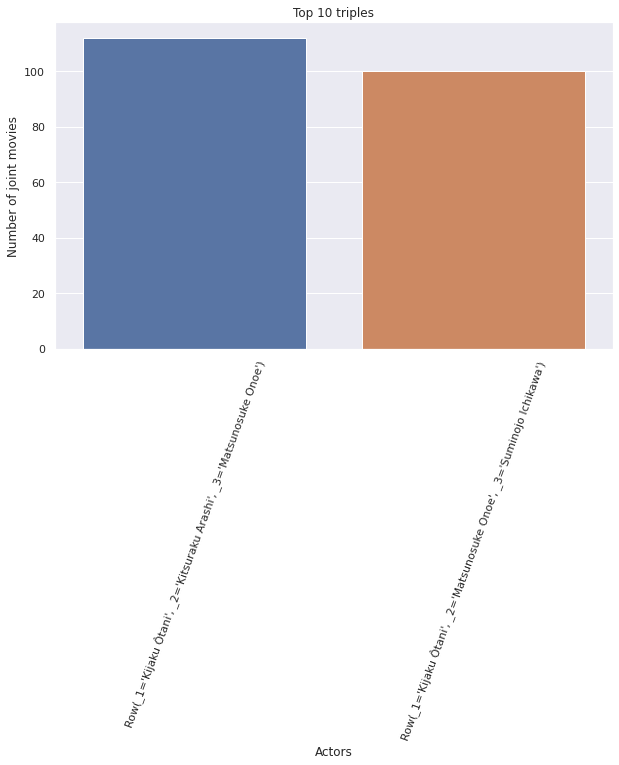

In [22]:
# plot top 10 frequent triples
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.barplot(x = "actors", y = "joint_apperaneces", data = result_triple_pdf[:10])
ax.set(title = "Top 10 triples", xlabel = "Actors", ylabel = "Number of joint movies")
ax.set_xticklabels(ax.get_xticklabels(), rotation=70);

### 5.Frequent itemsets rules

In [23]:
for rule in rules:
    print(rule)
    
# we see all the itemsets have big value of lift : far above zero, we can trust them

{Bahadur} -> {Adoor Bhasi} (conf: 0.486, supp: 0.000, lift: 288.015, conv: 1.941)
{Adoor Bhasi} -> {Bahadur} (conf: 0.289, supp: 0.000, lift: 288.015, conv: 1.405)
{Jayabharati} -> {Adoor Bhasi} (conf: 0.535, supp: 0.000, lift: 317.088, conv: 2.145)
{Adoor Bhasi} -> {Jayabharati} (conf: 0.277, supp: 0.000, lift: 317.088, conv: 1.382)
{Prem Nazir} -> {Adoor Bhasi} (conf: 0.541, supp: 0.001, lift: 321.021, conv: 2.176)
{Adoor Bhasi} -> {Prem Nazir} (conf: 0.403, supp: 0.001, lift: 321.021, conv: 1.674)
{Thikkurisi Sukumaran Nair} -> {Adoor Bhasi} (conf: 0.473, supp: 0.000, lift: 280.569, conv: 1.895)
{Adoor Bhasi} -> {Thikkurisi Sukumaran Nair} (conf: 0.210, supp: 0.000, lift: 280.569, conv: 1.265)
{Jayabharati} -> {Bahadur} (conf: 0.360, supp: 0.000, lift: 358.647, conv: 1.560)
{Bahadur} -> {Jayabharati} (conf: 0.313, supp: 0.000, lift: 358.647, conv: 1.455)
{Panchito} -> {Dolphy} (conf: 0.479, supp: 0.000, lift: 703.998, conv: 1.918)
{Dolphy} -> {Panchito} (conf: 0.432, supp: 0.000, li